# 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
# import cufflinks as cf
# import chart_studio.plotly as py
# import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from copy import deepcopy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# cf.go_offline(connected = True)

# 데이터 전처리

In [2]:
df1 = pd.read_csv('train.csv', index_col = 0)

In [3]:
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import nltk
from tqdm import tqdm
import re
from nltk.tokenize import TreebankWordTokenizer
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = TreebankWordTokenizer()


tqdm.pandas()
df_nltk = df1.copy()
pattern = re.compile('\d')

In [4]:
def clean_text(inputString):
    inputString_2 = re.sub('\d','',inputString)
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', '', inputString_2)
    text_rmv = ' '.join(text_rmv.split())
    return text_rmv

def make_lower(row):
    row['text'] = tokenizer.tokenize(row['text'])
    
    lst = []
    # 길이 1 제거
    for text in row['text']:
        text_2 = clean_text(text)
        
        if len(text_2.strip()) <= 1:
            pass
        else:
            lst.append(text_2)
            
    row['text'] = lst
    
    return row


In [5]:
df_nltk = df1.copy()

In [6]:
tqdm.pandas()

df_nltk_2 = df_nltk.progress_apply(make_lower, axis = 1).copy()

100%|██████████████████████████████████████████████████████████████████████████| 54879/54879 [00:20<00:00, 2673.16it/s]


In [7]:
lst_all = []
for i in df_nltk_2['text']:
    for j in i:
        lst_all.append(j)
        
        
df_word = pd.DataFrame(pd.Series(lst_all).value_counts())

df_nltk_3 = df_nltk_2.copy()
df_nltk_3.head()

,text,author
index,,
0,"[He, was, almost, choking, There, was, so, muc...",3
1,"[Your, sister, asked, for, it, suppose]",2
2,"[She, was, engaged, one, day, as, she, walked,...",1
3,"[The, captain, was, in, the, porch, keeping, h...",4
4,"[Have, mercy, gentlemen, odin, flung, up, his,...",3


In [8]:
preprocessed_sentences = df_nltk_3.loc[:,'text'].values.tolist()

In [9]:
vocab_size = 5000
tokenizer_1 = Tokenizer(num_words = vocab_size + 1)
tokenizer_1.fit_on_texts(preprocessed_sentences)



In [10]:
df_nltk_4 =df_nltk_3.copy()

a  = tokenizer_1.texts_to_sequences(df_nltk_3['text'])

df_nltk_4['text'] = [i for i in a]

train_dataset = df_nltk_4.copy()

In [11]:
# print('단어 OOV의 인덱스 : {}'.format(tokenizer_1.word_index['OOV']))

# 모델 설명 및 진행

- 모델은 nn.EmbeddingBag 레이어와 분류(classification) 목적을 위한 선형 레이어로 구성됩니다. 기본 모드가 《평균(mean)》인 nn.EmbeddingBag 은 임베딩들의 《가방(bag)》의 평균 값을 계산합니다. 이때 텍스트(text) 항목들은 각기 그 길이가 다를 수 있지만, nn.EmbeddingBag 모듈은 텍스트의 길이를 오프셋(offset)으로 저장하고 있으므로 패딩(padding)이 필요하지는 않습니다.

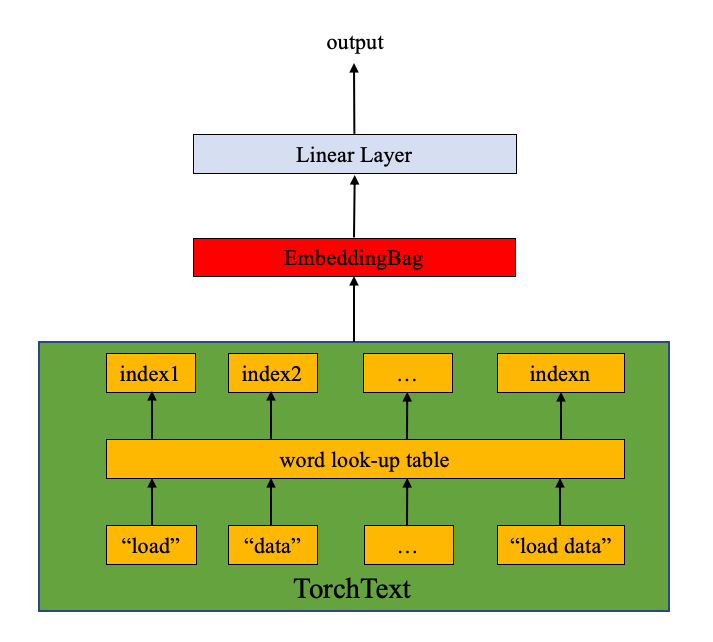

In [12]:
from IPython.display import Image
Image("text_sentiment_ngrams_model.png")
# https://tutorials.pytorch.kr/beginner/text_sentiment_ngrams_tutorial.html

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)
print (device)

cuda


In [14]:
train_dataset

,text,author
index,,
0,"[7, 11, 234, 34, 11, 31, 91, 31, 91, 7, 414, 3...",3
1,"[48, 288, 139, 16, 9, 323]",2
2,"[25, 11, 783, 41, 136, 17, 25, 353, 6, 546, 11...",1
3,"[1, 341, 11, 6, 1, 981, 110, 1338, 55, 4, 1, 1...",4
4,"[23, 1435, 440, 5, 1658, 57, 12, 196, 151, 594...",3
...,...,...
54874,"[22, 10, 8, 51, 1303, 5, 713, 370, 1575, 266, ...",2
54875,"[206, 21, 1210, 3, 1, 341, 2, 257, 94, 40, 738...",4
54876,"[48, 2512, 209, 2, 288, 1520, 5]",1


## Custom Dataset

- 예제의 데이터 셋과 여기의 데이터 셋은 다르므로, CustomDataset 객체를 활용하여 DataLoader을 만들어야 한다.

In [15]:
from torch.utils.data import DataLoader, Subset, Dataset

In [16]:
device

'cuda'

In [17]:
class CustomDataset(Dataset):
    def __init__(self,data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx): # Dataloader로 호출시 하나씩 가져옴 (__getitem__은 index slicing을 가능하게 함)
        text_data = self.data['text'][idx]
        label_data = self.data['author'][idx]
        label = torch.tensor(label_data, dtype=torch.int64)
        return  text_data, label.to(torch.long)
        
    
    

In [18]:
x_all,x_test, _, _ = train_test_split(train_dataset.index,train_dataset,
                                                   test_size= 0.2, shuffle = True,stratify= train_dataset.author)

In [19]:
x_train,x_valid, _, _ = train_test_split(train_dataset.iloc[x_all].index, train_dataset.iloc[x_all],
                                         test_size= 0.2, shuffle = True,
                                        stratify= train_dataset.iloc[x_all].author)

In [20]:
total_custom = CustomDataset(train_dataset)

In [21]:
train_subset = train_dataset.iloc[x_train].reset_index(drop = True)
valid_subset = train_dataset.iloc[x_valid].reset_index(drop = True)
test_subset = train_dataset.iloc[x_test].reset_index(drop = True)

In [22]:
train_custom = CustomDataset(train_subset)
valid_custom = CustomDataset(valid_subset)
test_custom = CustomDataset(test_subset)

In [23]:
def collate_fn(batchDummy): 
    x = [torch.LongTensor(batch[0])for batch in batchDummy] 
    y = [torch.LongTensor(batch[1])for batch in batchDummy] 

    # batch단위로 데이터가 넘어올 때 아래 pad_sequence를 통해 알아서 padding을 해준다
    x = torch.nn.utils.rnn.pad_sequence(x, batch_first = True) 
    return x, torch.tensor(y, dtype=torch.int64)

In [24]:
batch_size = 64
train_loader = DataLoader(train_custom, batch_size = batch_size, shuffle = True,collate_fn = collate_fn)
valid_loader = DataLoader(valid_custom, batch_size = batch_size, shuffle = True,collate_fn = collate_fn)
test_loader = DataLoader(test_custom, batch_size = batch_size, shuffle = True,collate_fn = collate_fn)

## Training 단계

In [25]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf
     
    for epoch in range(n_epochs):
        # train the model
        train_correct, train_loss = 0, 0
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_loader:
            x_minibatch = x_minibatch.type(torch.long)
            x_minibatch = x_minibatch.to(device)
            
            y_minibatch = y_minibatch.type(torch.long)
            y_minibatch = y_minibatch.to(device)
            
            y_minibatch_pred = model(x_minibatch)
            loss = loss_func(y_minibatch_pred,y_minibatch)
            
            train_pred = torch.argmax(y_minibatch_pred, dim = 1)
            train_correct += train_pred.eq(y_minibatch).sum().item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss) # 각 batch의 평균 loss를 계산하여 전체적으로 보겠다
        # validate the model
        
        valid_correct,valid_loss = 0,0
        
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in valid_loader:
                x_minibatch = x_minibatch.type(torch.long)
                x_minibatch = x_minibatch.to(device)
                y_minibatch = y_minibatch.type(torch.long)
                y_minibatch = y_minibatch.to(device)
                y_minibatch_pred = model(x_minibatch)
                loss = loss_func(y_minibatch_pred ,y_minibatch)
                valid_loss += loss.item() # loss 값 자체를 합함(나중에 평균)

                valid_pred = torch.argmax(y_minibatch_pred, dim = 1)
                valid_correct += valid_pred.eq(y_minibatch).sum().item()
                
        valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)
        
        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
            
            torch.save(best_model, 'best_dl_Final_LSTM.pt')
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                model.load_state_dict(best_model)
                break
                
        if (epoch % progress_interval) == 0: # 원하는 배수 마다 값이 반환되도록 설정 가능
            
            
            
            print('train_losses : {}, valid_loss : {}, lowest_loss : {}, lowest_epoch : {}, epoch :{}'
                  .format(train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch))
            print('Train_accuracy: {} / {} ({:.2f} %)'
                  .format(train_correct, len(train_loader.dataset),100 * train_correct / len(train_loader.dataset)))
            print('Valid_accuracy: {} / {} ({:.2f} %)'
                  .format(valid_correct, len(valid_loader.dataset),100 * valid_correct / len(valid_loader.dataset)),end = '\n\n') 
            
            
    
    model.load_state_dict(best_model) # 저장되어진 가장 나은 가중치 값을 load
    return model, lowest_loss, train_losses, valid_losses

## 모델링 단계

In [26]:
class TextClassificationModel(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, hidden_size,num_layers,dropout_p, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) 
        # 정수 인코딩 되어진 단어를 벡터화, Gradient를 sparse -> 더빠름
        self.init_weights()
        self.fc = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, num_class),
            nn.LogSoftmax(dim = -1)
        )

        
        self.sequenceclassifier = nn.LSTM(
            input_size = embed_dim,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout_p
        )
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight.data)
        
    def forward(self,text):
        embedded = self.embedding(text)
        output, _ = self.sequenceclassifier(embedded)

        output = output[:,-1]# many to one.

        return self.fc(output)
        

In [27]:
vocab_size = tokenizer_1.num_words
embed_dim = 32
num_class = len(np.unique(train_dataset['author']))
hidden_size = 128
num_layers = 4
dropout_p = 0.3
model = TextClassificationModel(vocab_size, embed_dim,hidden_size,num_layers, dropout_p,num_class).to(device)

In [28]:
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training 및 Validation

In [29]:
nb_epochs = 1000 
progress_interval = 1
early_stop = 40



model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

train_losses : 1.584468582071676, valid_loss : 1.5708959387696309, lowest_loss : 1.5708959387696309, lowest_epoch : 0, epoch :0
Train_accuracy: 9019 / 35122 (25.68 %)
Valid_accuracy: 2410 / 8781 (27.45 %)

train_losses : 1.569600185409921, valid_loss : 1.8189306138218313, lowest_loss : 1.5708959387696309, lowest_epoch : 0, epoch :1
Train_accuracy: 9514 / 35122 (27.09 %)
Valid_accuracy: 2377 / 8781 (27.07 %)

train_losses : 1.3359499025431705, valid_loss : 1.7819581662399182, lowest_loss : 1.5708959387696309, lowest_epoch : 0, epoch :2
Train_accuracy: 14363 / 35122 (40.89 %)
Valid_accuracy: 2965 / 8781 (33.77 %)

train_losses : 1.0352720388080687, valid_loss : 1.1018030431823453, lowest_loss : 1.1018030431823453, lowest_epoch : 3, epoch :3
Train_accuracy: 20354 / 35122 (57.95 %)
Valid_accuracy: 5046 / 8781 (57.46 %)

train_losses : 0.8678435337999479, valid_loss : 1.4414758215779844, lowest_loss : 1.1018030431823453, lowest_epoch : 3, epoch :4
Train_accuracy: 23264 / 35122 (66.24 %)
Val

train_losses : 0.14569084760894108, valid_loss : 1.650560616583064, lowest_loss : 0.8666277774002241, lowest_epoch : 8, epoch :40
Train_accuracy: 33317 / 35122 (94.86 %)
Valid_accuracy: 5854 / 8781 (66.67 %)

train_losses : 0.1455909546841282, valid_loss : 1.705187598000402, lowest_loss : 0.8666277774002241, lowest_epoch : 8, epoch :41
Train_accuracy: 33284 / 35122 (94.77 %)
Valid_accuracy: 5869 / 8781 (66.84 %)

train_losses : 0.13281531577661823, valid_loss : 1.6519838722719662, lowest_loss : 0.8666277774002241, lowest_epoch : 8, epoch :42
Train_accuracy: 33498 / 35122 (95.38 %)
Valid_accuracy: 5859 / 8781 (66.72 %)

train_losses : 0.1322173572913871, valid_loss : 1.7721319094948147, lowest_loss : 0.8666277774002241, lowest_epoch : 8, epoch :43
Train_accuracy: 33478 / 35122 (95.32 %)
Valid_accuracy: 5819 / 8781 (66.27 %)

train_losses : 0.1306715109478852, valid_loss : 1.7336155681506447, lowest_loss : 0.8666277774002241, lowest_epoch : 8, epoch :44
Train_accuracy: 33548 / 35122 (95.

# Testing

- 결과 값이 Overfitting이 나옴

In [30]:
test_loss = 0 
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.to('cpu')

model.eval()
with torch.no_grad(): # gradient 추적 끝
    for x_minibatch, y_minibatch in test_loader:
        y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        test_loss += loss_func(y_test_pred, y_minibatch)
        pred = torch.argmax(y_test_pred, dim = 1)
        correct += pred.eq(y_minibatch).sum().item()
        # 똑같은 것의 idx (pred 와 y값이)
        
        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
        # 다른 것의 idx 
    
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index])
            wrong_preds.append(pred[index])
            actual_preds.append(y_minibatch[index])
            
test_loss /= len(test_loader.dataset)
print('Average Tess Loss {:.4f}'.format(test_loss))
print('Accuracy: {} / {} ({:.2f} %)'.format(correct, len(test_loader.dataset),100 * correct / len(test_loader.dataset))) 
      # 맞는 것과 전체 비율 계산
        

Average Tess Loss 0.0136
Accuracy: 7562 / 10976 (68.90 %)
